<a href="https://colab.research.google.com/github/raphamatoss/DeepLearningWithPyTorch/blob/main/PyTorchWorkflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Data: prepare and load
2. Build a model
3. Fit the model to the data(training)
4. Make predictions and evaluate a model
5. Save and load a model
6. Put it all together

In [ ]:
import torch
from torch import nn # nn contains all of PyTorcg's building blocks for neural networks
import matplotlib.pyplot as plt

**1. DATA**

Data can be almost everything:
- DNA
- Imagens
- Music
- Text

We need to turn data into numbers and then build a model to learn patters in the numbers.
To showcase this, let´s create some known data using the linear regression formula. We'll make a straight line with know parameters.

In [ ]:
# Create known parameters
weight = 0.7
bias = 0.3

X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
len(X), len(y)

(50, 50)

**Splitting Data**

Training and testing sets are essencial in ML/DL, this division allow us to evaluate our model. There is also often a validation set, but it's not mandatory.

In [ ]:
# Create a train/test split
train_split =  int(0.8 * len(X))
X_train, y_train =  X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [51]:
# Let's create a function to visualize our data!
import torch

def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compare predictions
  """
  plt.figure(figsize=(10, 7))

  ### Plot training data in blue
  # matplotlib.pyplot.scatter takes (x=train_data, y=train_label) as the data position
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training set")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing set")

  if predictions is not None:
    # Plot the predictions in red(predictions made on the test data)
    numpy_predictions = predictions.detach().numpy()
    plt.scatter(test_data, numpy_predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 14})


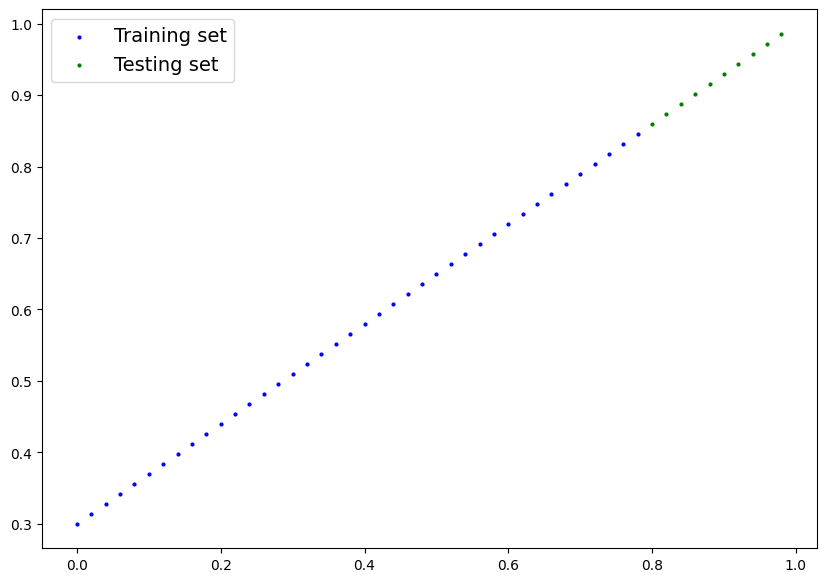

In [ ]:
plot_predictions()

**2. Build a Model**

First PyTorch model


In [ ]:
import torch
from torch import nn

# creating a linear regression model class
class LinearRegressionModel(nn.Module): #nn.Module is a superclass to all models  in PyTorch
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.rand(1, requires_grad=True))
    self.bias = nn.Parameter(torch.rand(1, requires_grad=True))

  #forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # "x" is the input data
    return self.weights * x + self.bias


**PyTorch Model Building Essentials**

`torch.nn` contains all of the building blocks for computational graphs

`torch.nn.Parameter` what a should model try and learn, often a PyTorch layer from torch.nn will set these for us

`torch.nn.Module` the super class for all neural network classes, if we subclass it, we should overwrite forward()

`torch.optim` the optimizers implemented by PyTorch

`def forward()` all nn.Module subclasses requires the method to be overwritten, this method defines what happens in the forward computation

**Checking the contents of our PyTorch model**

We can check our model parameters using `.parameters()`

In [ ]:
torch.manual_seed(42)

model = LinearRegressionModel()

list(model.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [ ]:
# List named parameters
model.state_dict()

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

**Making predictions using  `torch.inference_mode()`**

To check our model's predictive power, let's see how well it predicts `y_test` based on `X_test`. When we pass data through our model, its going to tun it through the `forward()` method.

In [ ]:
with torch.inference_mode(): # inference mode disables background functions such as backpropagation
  y_preds = model(X_test)

y_preds

tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]])

In [ ]:
# we could also use:
y_preds = model(X_test)
y_preds

tensor([[1.6208],
        [1.6385],
        [1.6561],
        [1.6738],
        [1.6914],
        [1.7090],
        [1.7267],
        [1.7443],
        [1.7620],
        [1.7796]], grad_fn=<AddBackward0>)

In [ ]:
# what we expected:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

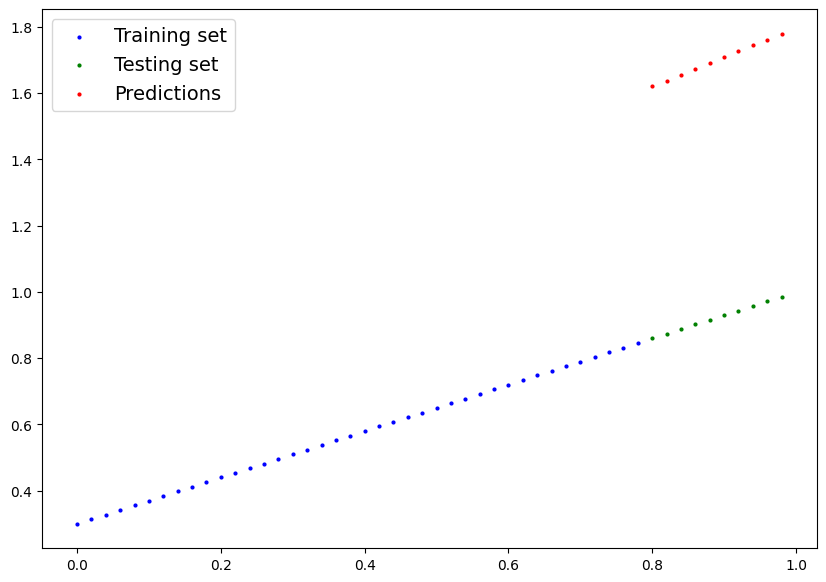

In [ ]:
plot_predictions(predictions=y_preds)

**3. Training a model**

The concept of training a model is to move from some unknown parameters(probably random) to some known parameters that better represents our data

One way to measure how poor our models predictions are is to use a loss function, also called cost function.

*Loss Function:* a function that measures how wrong the model's predictions are to the ideal output. Lower is better.

*Optimizer:* takes the loss of the model and adjust the model's parameters to reduce the loss

With PyTorch we nedd:
- A training loop
- A testing loop

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [ ]:
model.state_dict()

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

In [ ]:
#Setting up a loss function
loss_f = nn.L1Loss()

#setting up an optimizer(sgd)
optimizer = torch.optim.SGD(params=model.parameters(), lr= 0.01)  #lr = learning rate

**Building a training loop (and a testing loop)**

Steps:
1. Loop through the data
2. Forward pass(data passing through `forward()` method of the model) to make predictions on data
3. Calculate the loss
4. Optimizer zero grad
5. Loss backward -> move backwards through the network to calculate the gradients of each of the parameters of the model with respect to the loss(**backpropagation**)
6. Optimizer step -> use the optimizer to adjust the model's parameters to try to improve the loss(**gradient descent**)


In [ ]:
# An epoch is one loop through the data
epochs = 100;

# Tracking values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 1. loop through the data
for epoch in range(epochs):
  # set the model to training mode
  model.train() #train mode in PyToch sets all parameters that require gradients to require gradients

  y_predictions = model(X_train) #performs the forward pass of the data through the model

  loss = loss_f(y_predictions, y_train) #calculate the loss between the prediction and the labels

  optimizer.zero_grad() #set the optimizer'gradients to zero before performing the backpropation, otherwise the gradients would accumulate

  loss.backward() # perfoms the backpropagation on the loss

  optimizer.step() #updates the parameters of the model with respect to the result of the backpropagation

  ###Testing
  model.eval() # turns off a variaty of settings that are not needed for evaluation/testing
  with torch.inference_mode():
    test_pred = model(X_test) # do the forward pass

    test_loss = loss_f(test_pred, y_test) # calculate the loss

  epoch_count.append(epoch)
  loss_values.append(loss)
  test_loss_values.append(test_loss)

  print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.6860889196395874 | Test Loss: 0.7637526988983154
Epoch: 1 | Loss: 0.6745679974555969 | Test Loss: 0.7502816915512085
Epoch: 2 | Loss: 0.6630470156669617 | Test Loss: 0.7368106245994568
Epoch: 3 | Loss: 0.6515260338783264 | Test Loss: 0.7233396768569946
Epoch: 4 | Loss: 0.6400049924850464 | Test Loss: 0.7098686695098877
Epoch: 5 | Loss: 0.6284840703010559 | Test Loss: 0.6963977217674255
Epoch: 6 | Loss: 0.6169630289077759 | Test Loss: 0.6829267144203186
Epoch: 7 | Loss: 0.6054420471191406 | Test Loss: 0.6694557666778564
Epoch: 8 | Loss: 0.5939210653305054 | Test Loss: 0.6559847593307495
Epoch: 9 | Loss: 0.5824000239372253 | Test Loss: 0.6425138115882874
Epoch: 10 | Loss: 0.5708791017532349 | Test Loss: 0.6290428042411804
Epoch: 11 | Loss: 0.5593580603599548 | Test Loss: 0.6155718564987183
Epoch: 12 | Loss: 0.5478371381759644 | Test Loss: 0.6021007895469666
Epoch: 13 | Loss: 0.5363161563873291 | Test Loss: 0.5886298418045044
Epoch: 14 | Loss: 0.5247951149940491 | Test 

In [ ]:
model.state_dict()

OrderedDict([('weights', tensor([0.6977])), ('bias', tensor([0.3080]))])

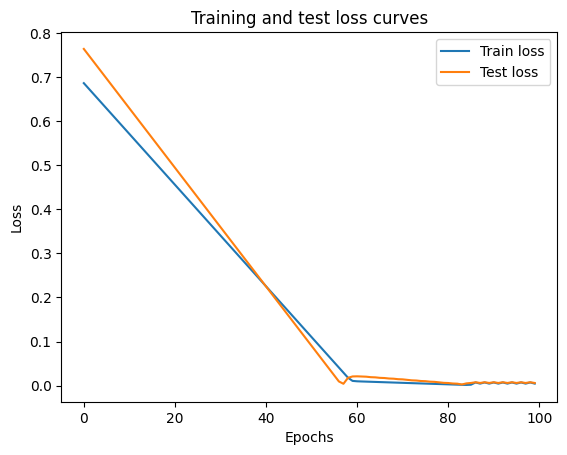

In [ ]:
import numpy as np

# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
with torch.inference_mode():
  y_preds_new = model(X_test)

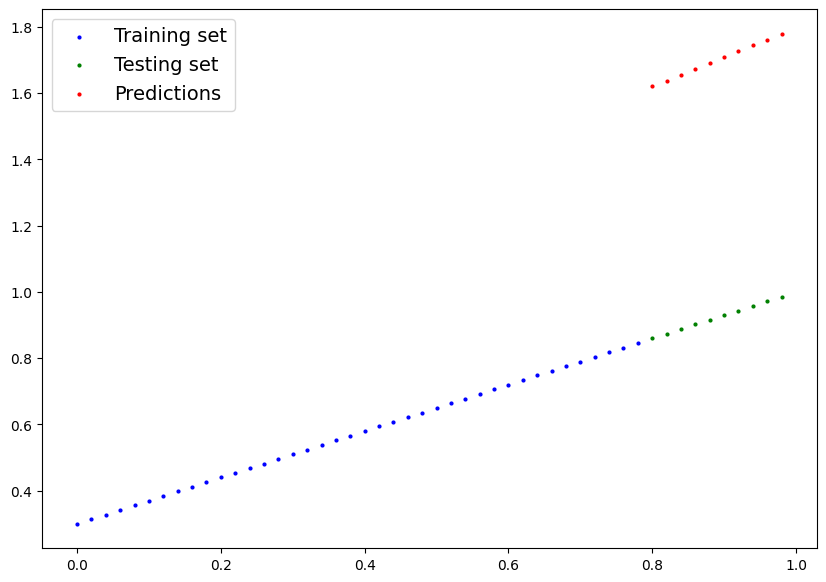

In [ ]:
plot_predictions(predictions=y_preds)

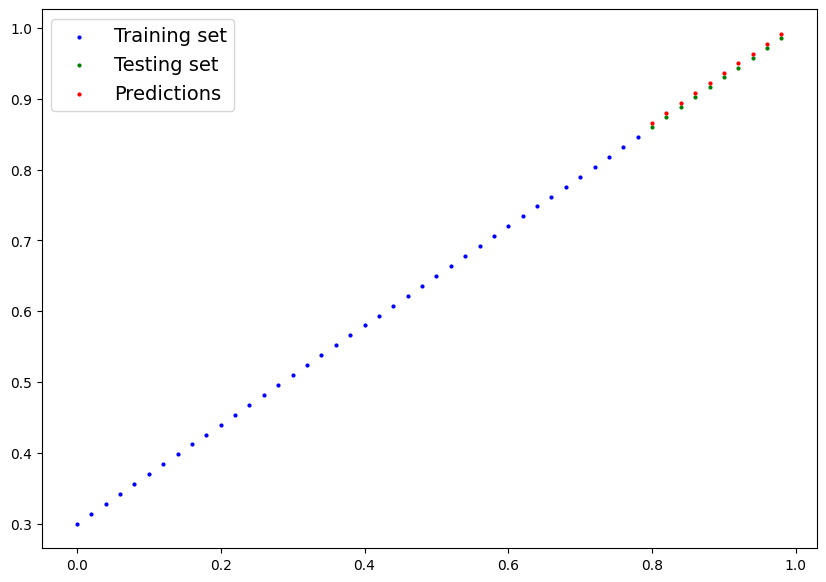

In [ ]:
plot_predictions(predictions=y_preds_new)

**Saving a model in PyTorch**

There are three main methods for saving and loading models:
1. `torch.save()` -> saves a model's state dictionary or own model
2. `torch.load()` -> loads the model or the state dictionary file
3. `torch.nn.Module.load_state_dict()` -> this allows to load a model's saved dictionary

Doc: https://pytorch.org/tutorials/beginner/saving_loading_models.html

**Saving the state dictionary**

In [ ]:
# Saves the model's state_dict()
torch.save(model.state_dict(), "model_state_dict.pt")

In [ ]:
# Loads the model's state_dict()
saved_model_1 = LinearRegressionModel()
saved_model_1.load_state_dict(torch.load("model_state_dict.pt", weights_only=True))
saved_model_1.eval()

LinearRegressionModel()

**Saving the entire model**

In [ ]:
# Saves the model
torch.save(model, "model.pt")

In [ ]:
# Loads a saved model
saved_model_2 = torch.load("model.pt", weights_only=False)
saved_model_2.eval()

LinearRegressionModel()

**Saving the entire model using script**

When saving the model using `torch.save()` it may cause some issues. To avoid that we can use:

In [ ]:
# Saves the model
model_scripted = torch.jit.script(model) # exporting the model
model_scripted.save("model_scripted.pt") # saving it

In [ ]:
# Loads the model
model_saved_3 = torch.jit.load("model_scripted.pt")
model_saved_3.eval()

RecursiveScriptModule(original_name=LinearRegressionModel)

### **Putting everything together**


In [40]:
import torch
import torch.nn as nn

# Creating some data
weight = 0.5
bias = 0.1

X = torch.arange(start=0, end=10, step=0.2).unsqueeze(dim=1)
y = weight*X + bias

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# Creating the model
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.dense_layer_1 = nn.Linear(in_features=1, out_features=1)

  def forward(self, x = torch.Tensor) -> torch.Tensor:
    x = self.dense_layer_1(x)
    return x

# Setting the seed
torch.manual_seed(42)

model = LinearRegressionModelV2()
model, model.state_dict()

# Moving the model and data to the GPU
if (torch.cuda.is_available()):
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

model.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Creating and setting the loss function and the optimizer
loss_function = nn.L1Loss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

# Creating the training and testing loop
epochs = 150

epochs_list = []
loss_list = []
test_loss_list = []

for epoch in range(epochs):
  model.train()

  y_pred = model(X_train)

  loss = loss_function(y_pred, y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model.eval()
  with torch.inference_mode():
    test_pred = model(X_test)

    test_loss = loss_function(test_pred, y_test)

  if (epoch % 10 == 0):
    epochs_list.append(epoch)
    loss_list.append(loss)
    test_loss_list.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

model.state_dict()

Epoch: 0 | Loss: 1.7617082595825195 | Test Loss: 2.7273013591766357
Epoch: 10 | Loss: 0.26677969098091125 | Test Loss: 0.3858579099178314
Epoch: 20 | Loss: 0.2491065263748169 | Test Loss: 0.34447869658470154
Epoch: 30 | Loss: 0.23193858563899994 | Test Loss: 0.328519344329834
Epoch: 40 | Loss: 0.21477055549621582 | Test Loss: 0.3125600516796112
Epoch: 50 | Loss: 0.19746653735637665 | Test Loss: 0.2711807191371918
Epoch: 60 | Loss: 0.1802985519170761 | Test Loss: 0.2552213966846466
Epoch: 70 | Loss: 0.16313053667545319 | Test Loss: 0.23926205933094025
Epoch: 80 | Loss: 0.145826518535614 | Test Loss: 0.19788289070129395
Epoch: 90 | Loss: 0.12865851819515228 | Test Loss: 0.18192355334758759
Epoch: 100 | Loss: 0.11157584190368652 | Test Loss: 0.14232411980628967
Epoch: 110 | Loss: 0.09422246366739273 | Test Loss: 0.12725472450256348
Epoch: 120 | Loss: 0.07712282240390778 | Test Loss: 0.08854508399963379
Epoch: 130 | Loss: 0.06177443265914917 | Test Loss: 0.10329518467187881
Epoch: 140 | Lo

OrderedDict([('dense_layer_1.weight', tensor([[0.4953]], device='cuda:0')),
             ('dense_layer_1.bias', tensor([0.1885], device='cuda:0'))])

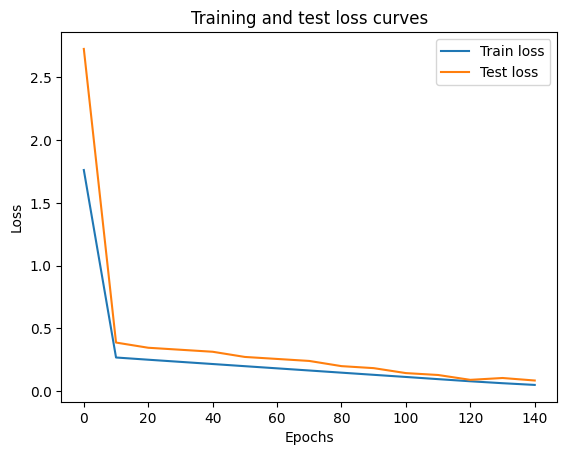

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the loss curves
plt.plot(epochs_list, np.array(torch.tensor(loss_list).numpy()), label="Train loss")
plt.plot(epochs_list, np.array(torch.tensor(test_loss_list).numpy()), label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [56]:
model.eval()
with torch.inference_mode():
  y_predictions = model(X_test)
y_predictions

tensor([[4.1512],
        [4.2503],
        [4.3493],
        [4.4484],
        [4.5475],
        [4.6465],
        [4.7456],
        [4.8447],
        [4.9438],
        [5.0428]], device='cuda:0')

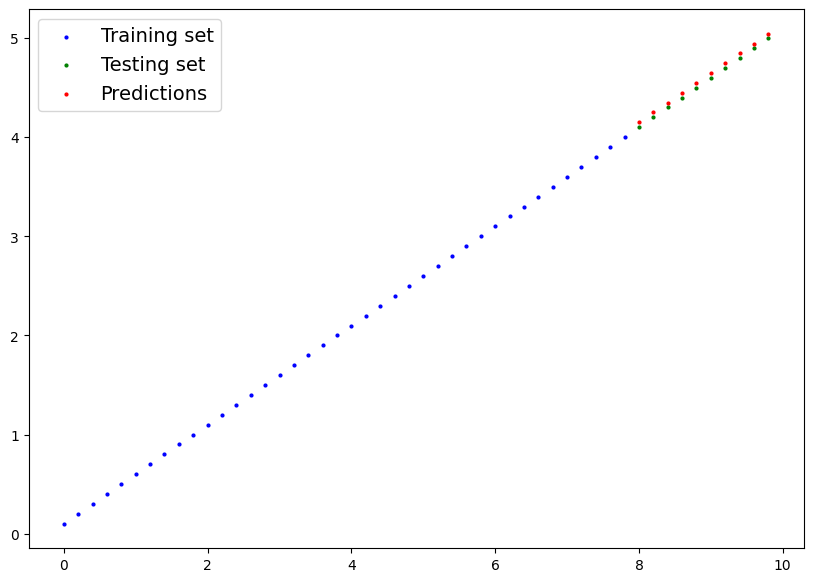

In [58]:
plot_predictions(train_data=X_train.cpu(), train_labels=y_train.cpu(), test_data=X_test.cpu(), test_labels=y_test.cpu(), predictions=y_predictions.cpu())